In [26]:
import torch
import time
import numpy as np
import torch.nn as nn
from scipy.ndimage import binary_closing, binary_opening, generate_binary_structure

import matplotlib.pyplot as plt


In [ ]:
# AUGMENTATIONS 

flip_axes = [[], [2], [3], [4], [2,3], [2,4], [3,4], [2,3,4]]
shifts = [
    (0, 0, 0),
    (10, 0, 0), (-10, 0, 0),
    (0, 10, 0), (0, -10, 0),
    (0, 0, 10), (0, 0, -10),
]

In [ ]:

def test_time_augmentation(model, input_tensor, threshold=0.5, morph_op='closing'):
    """
    Perform Test-Time Augmentation (TTA) with flip, circular shift, and postprocessing smoothing.

    Args:
        model (torch.nn.Module): The model to evaluate.
        input_tensor (torch.Tensor): A tensor of shape (1, 1, Z, X, Y)
        threshold (float): Threshold to binarize output before morphological operation
        morph_op (str): 'closing' or 'opening'

    Returns:
        torch.Tensor: Postprocessed prediction after TTA.
    """
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    predictions = []

    with torch.no_grad():
        for flip in flip_axes:
            for dz, dx, dy in shifts:
                augmented = input_tensor.clone()

                # Flip
                if flip:
                    augmented = torch.flip(augmented, dims=flip)

                # Shift
                augmented = torch.roll(augmented, shifts=(dz, dx, dy), dims=(2, 3, 4))

                # Model inference
                pred = model(augmented)

                # Undo shift
                pred = torch.roll(pred, shifts=(-dz, -dx, -dy), dims=(2, 3, 4))

                # Undo flip
                if flip:
                    pred = torch.flip(pred, dims=flip)

                predictions.append(pred)

    avg_prediction = torch.stack(predictions).mean(dim=0)

    # --- Morphological smoothing ---
    # Convert to NumPy for processing
    pred_np = avg_prediction.squeeze().cpu().numpy()

    # Binarize
    binary_pred = pred_np > threshold

    # Define 3D structuring element (connectivity-1, i.e., 6-connected)
    structure = generate_binary_structure(rank=3, connectivity=1)

    if morph_op == 'closing':
        smoothed = binary_closing(binary_pred, structure=structure)
    elif morph_op == 'opening':
        smoothed = binary_opening(binary_pred, structure=structure)
    else:
        raise ValueError("morph_op must be 'closing' or 'opening'")

    # Convert back to tensor (as float)
    smoothed_tensor = torch.tensor(smoothed, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
    return smoothed_tensor




In [ ]:
# Dummy model: just returns input with sigmoid (as if it were a segmentation mask)
class DummyModel(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape  # (C, Z, X, Y)
        flattened_size = np.prod(input_shape)
        self.param = nn.Parameter(torch.ones(flattened_size))

    def forward(self, x):
        B, C, Z, X, Y = x.shape
        x = x.view(B, -1)
        x = self.param * x
        x = torch.sigmoid(x)
        return x.view(B, C, Z, X, Y)

def test_tta():
    # Create dummy model and input
    model = DummyModel((1, 64, 128, 128))
    input_tensor = torch.randn(1, 1, 64, 128, 128)  # (B, C, Z, X, Y)

    # Run test-time augmentation
    output = test_time_augmentation(model, input_tensor, threshold=0.5, morph_op='closing')

    # Check output shape
    assert output.shape == input_tensor.shape, f"Output shape {output.shape} != input shape {input_tensor.shape}"

    # Check that output is binary (or nearly binary due to float conversion)
    unique_vals = torch.unique(output)
    assert unique_vals.numel() <= 2 or torch.all((unique_vals == 0) | (unique_vals == 1)), \
        f"Output not binary: unique values = {unique_vals}"

    print("Test passed: TTA with morphology returns correct output shape and binary values.")


In [ ]:
# Run the test
test_tta()

Test passed: TTA with morphology returns correct output shape and binary values.


In [12]:
def benchmark_inference(model, input_tensor):
    # Warm-up GPU (optional)
    _ = model(input_tensor)

    # --- Inference without TTA ---
    start = time.time()
    with torch.no_grad():
        output = model(input_tensor)
    plain_time = time.time() - start

    # --- Inference with TTA ---
    start = time.time()
    tta_output = test_time_augmentation(model, input_tensor, threshold=0.5, morph_op='closing')
    tta_time = time.time() - start

    # --- Report ---
    print(f"Inference without TTA: {plain_time:.4f} seconds")
    print(f"Inference with TTA:    {tta_time:.4f} seconds")
    print(f"TTA is {tta_time / plain_time:.1f}x slower")

    return output, tta_output

In [38]:
input_shape = (1, 64, 128, 128)
model = DummyModel(input_shape)
input_tensor = torch.randn(1, *input_shape)

model.eval()
print(f'Device: {"cuda" if torch.cuda.is_available() else "cpu"}')
model.to("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(next(model.parameters()).device)

output, tta_output = benchmark_inference(model, input_tensor)

Device: cuda
Inference without TTA: 0.0001 seconds
Inference with TTA:    0.0739 seconds
TTA is 906.9x slower


In [27]:
def visualize_augmentations(input_tensor):
    """
    Visualize how each TTA (flip or shift) changes the VOI in 3D input.
    Shows original, augmented, and de-augmented VOIs.
    
    Args:
        input_tensor: torch.Tensor of shape (1, 1, Z, X, Y)
    """
    input_np = input_tensor.squeeze().cpu().numpy()  # (Z, X, Y)
    center_z = input_np.shape[0] // 2
    original_slice = input_np[center_z]

    fig, axes = plt.subplots(len(flip_axes), len(shifts), figsize=(20, 20))
    fig.suptitle("Augmented VOIs (Z center slice)", fontsize=18)

    for i, flip in enumerate(flip_axes):
        for j, (dz, dx, dy) in enumerate(shifts):
            # Apply augmentation
            aug = input_tensor.clone()
            if flip:
                aug = torch.flip(aug, dims=flip)
            aug = torch.roll(aug, shifts=(dz, dx, dy), dims=(2, 3, 4))

            aug_np = aug.squeeze().cpu().numpy()
            aug_slice = aug_np[center_z]

            ax = axes[i][j]
            ax.imshow(aug_slice, cmap='gray')
            ax.axis('off')
            ax.set_title(f"Flip={flip}, Shift=({dz},{dx},{dy})", fontsize=8)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [36]:
def create_ellipsoid_mask(shape=(64, 128, 128), radii=(10, 20, 20)):
    """
    Create a binary mask with an ellipsoid in the center of a 3D volume.

    Args:
        shape (tuple): Shape of the volume (Z, X, Y)
        radii (tuple): Radii of the ellipsoid along Z, X, and Y

    Returns:
        torch.Tensor: Mask tensor of shape (1, 1, Z, X, Y)
    """
    Z, X, Y = shape
    z, x, y = np.ogrid[:Z, :X, :Y]

    # Center coordinates
    cz, cx, cy = Z // 2, X // 2, Y // 2

    # Ellipsoid equation
    ellipsoid = (((z - cz) / radii[0]) ** 2 +
                 ((x - cx) / radii[1]) ** 2 +
                 ((y - cy) / radii[2]) ** 2) <= 1

    mask = ellipsoid.astype(np.float32)  # binary mask
    mask_tensor = torch.tensor(mask).unsqueeze(0).unsqueeze(0)  # (1, 1, Z, X, Y)
    return mask_tensor

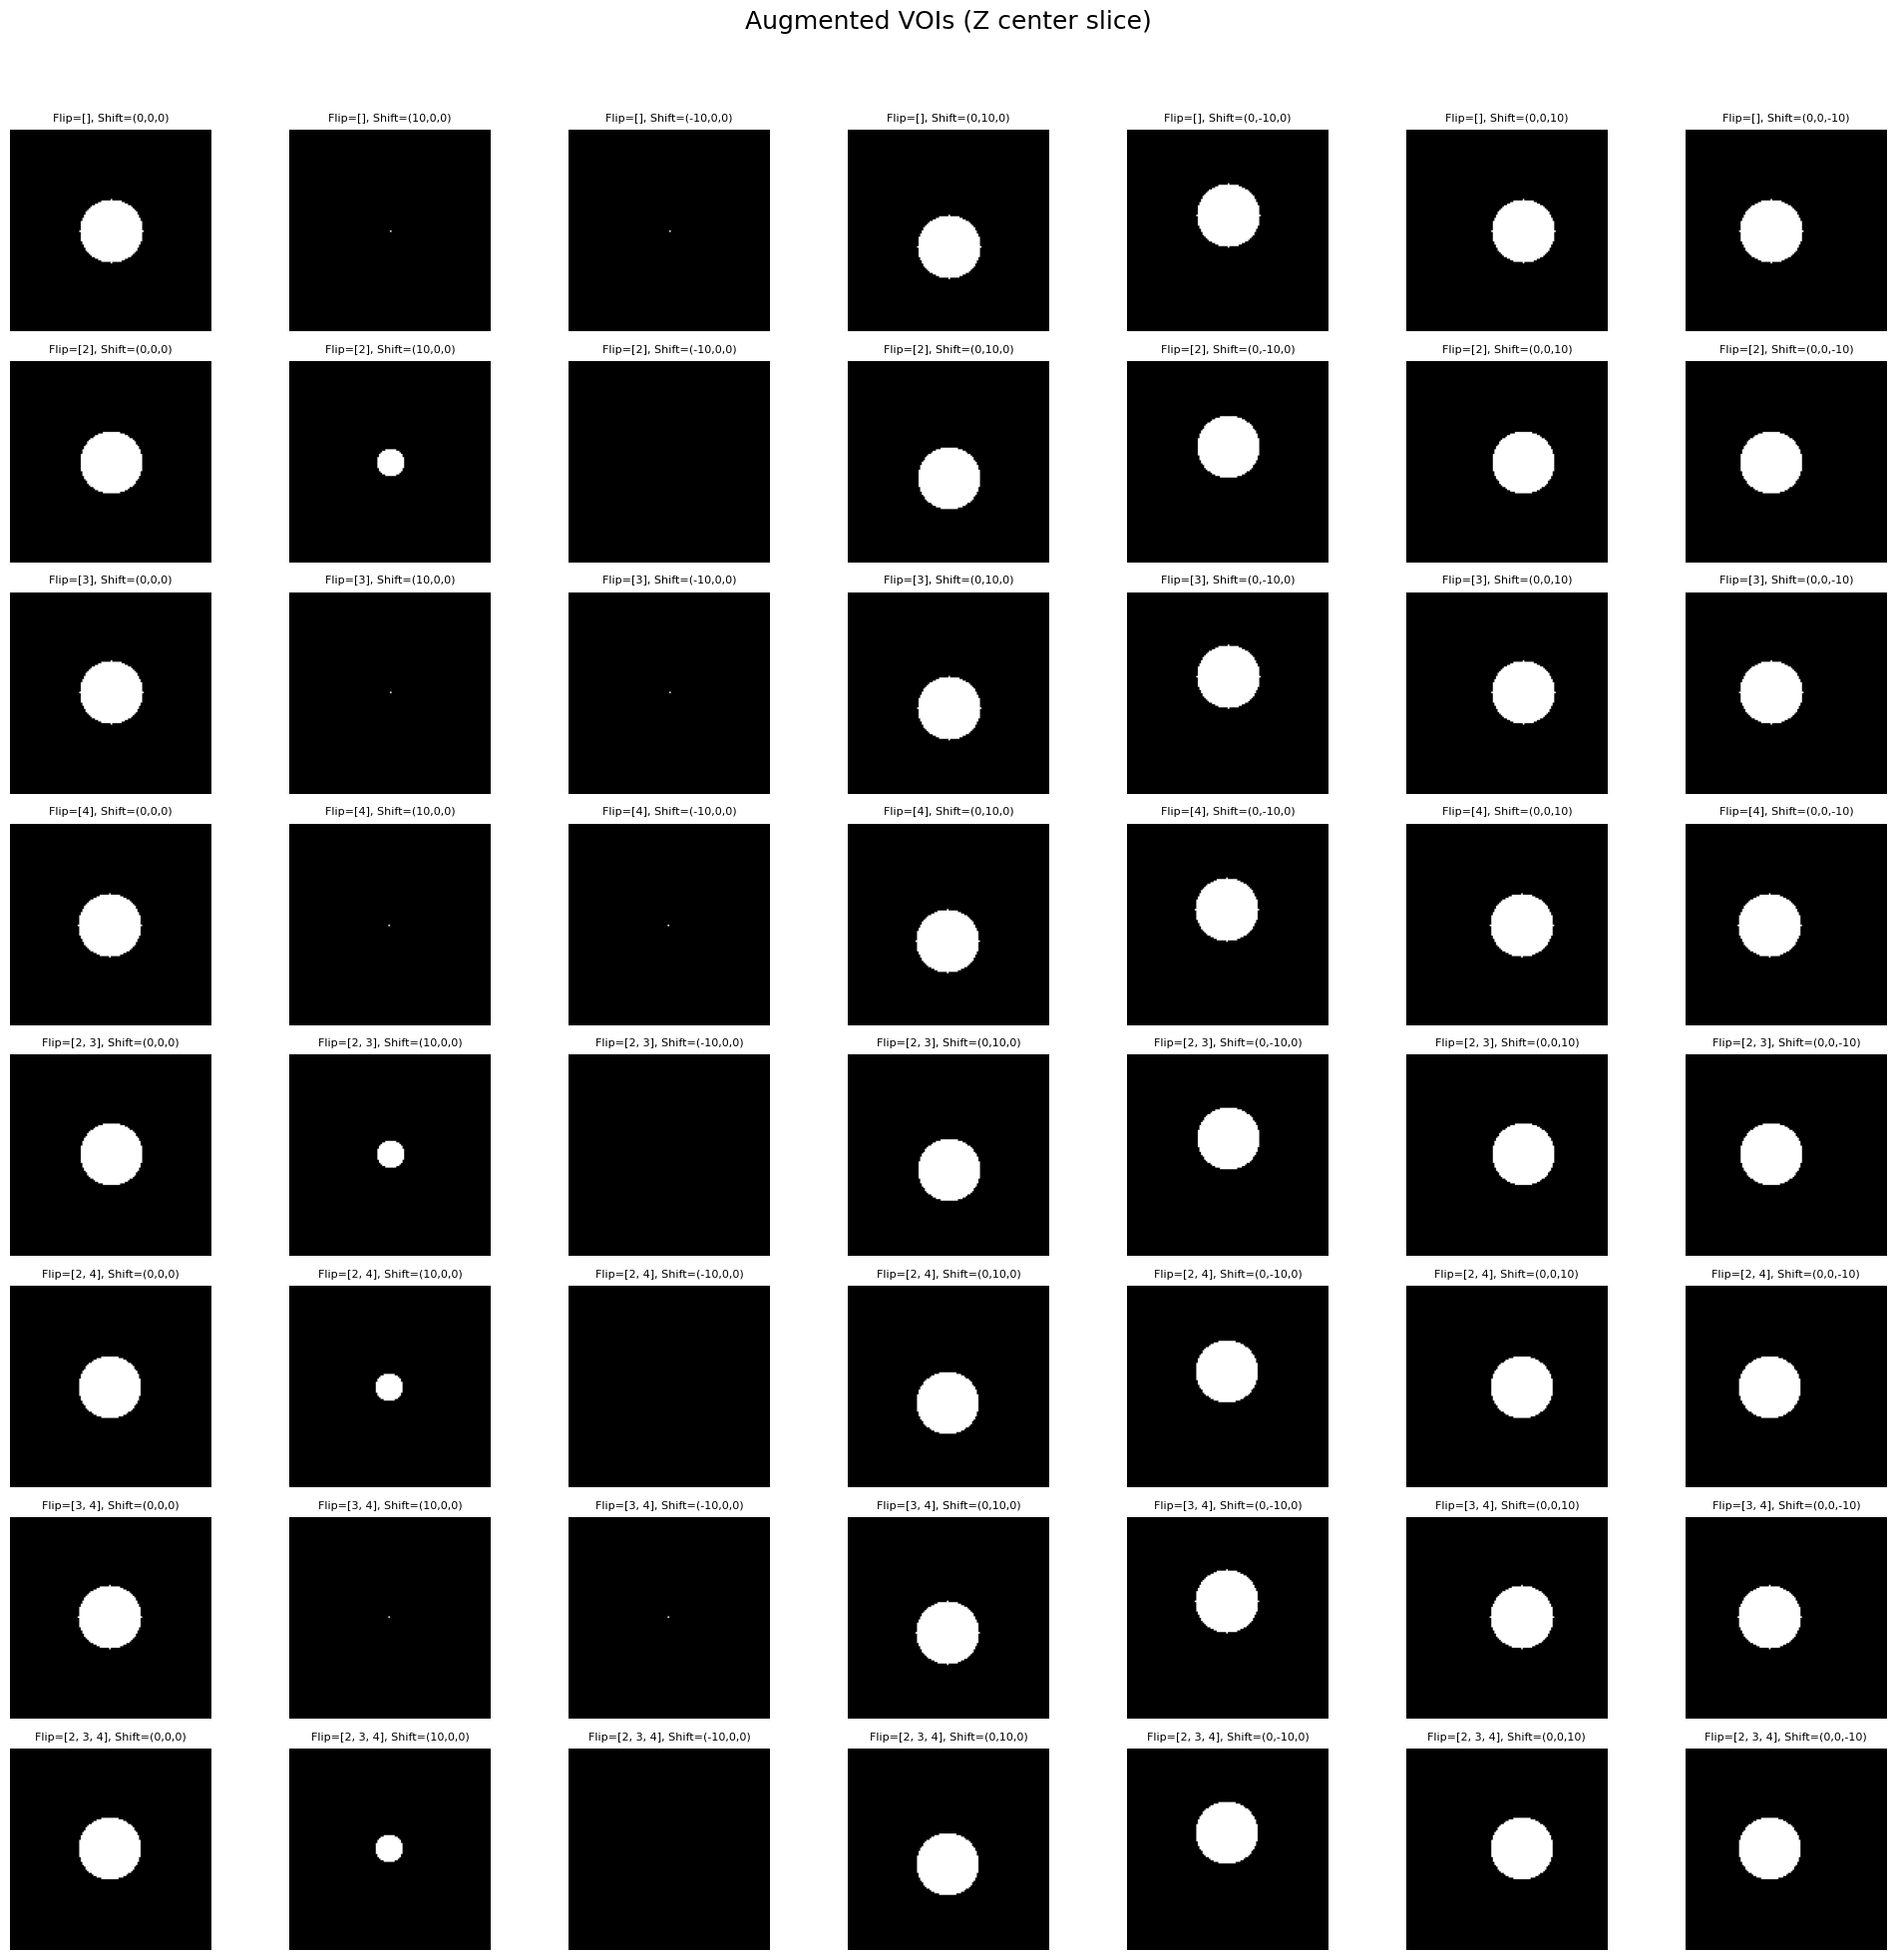

In [37]:
input_tensor = create_ellipsoid_mask()  # (B, C, Z, X, Y)
visualize_augmentations(input_tensor)